(5, 256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


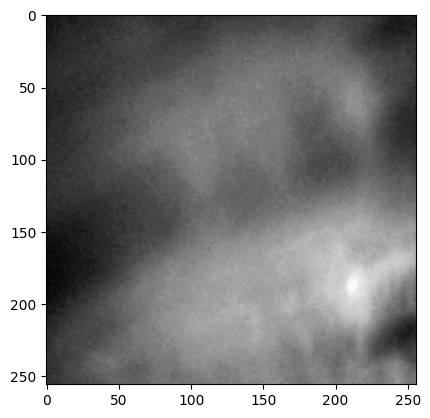

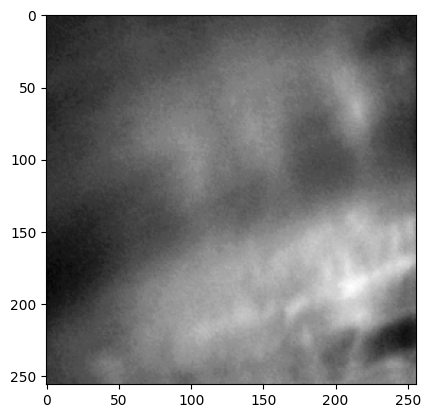

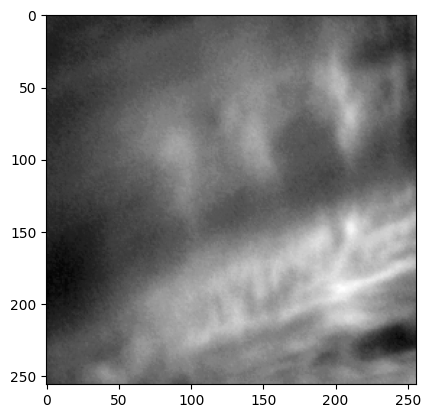

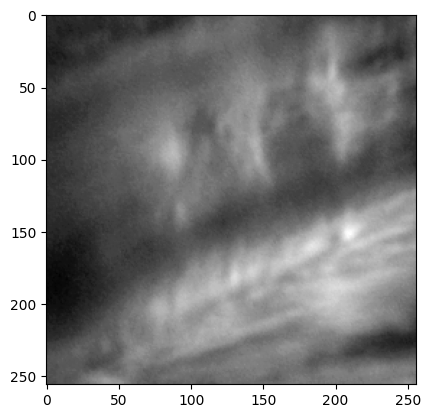

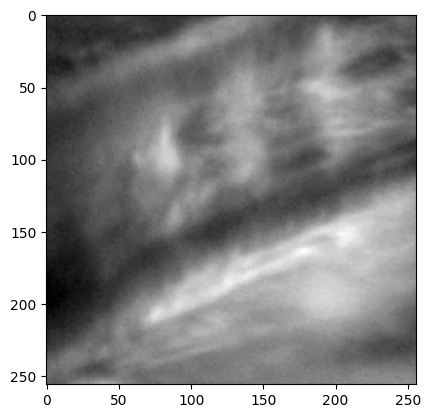

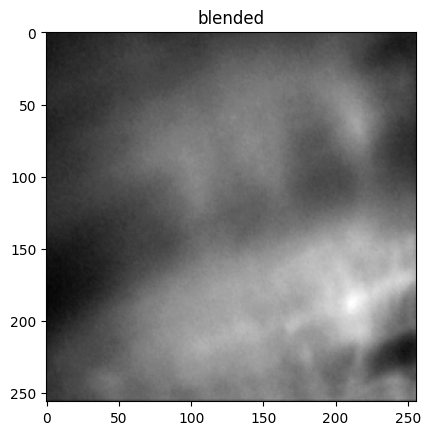

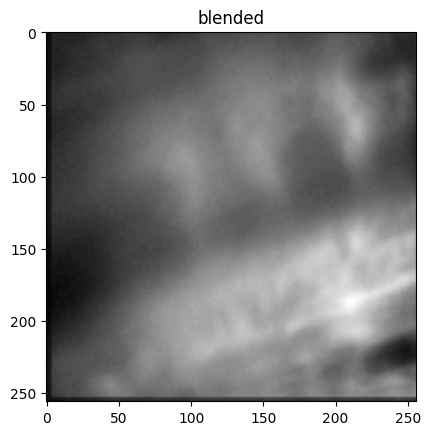

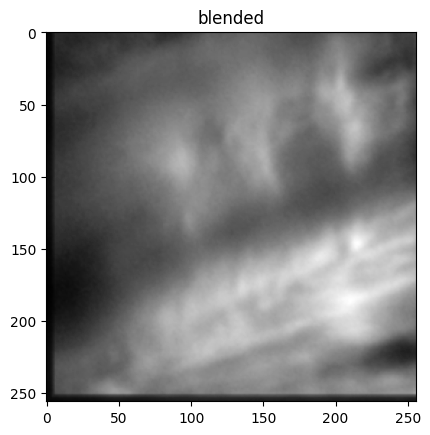

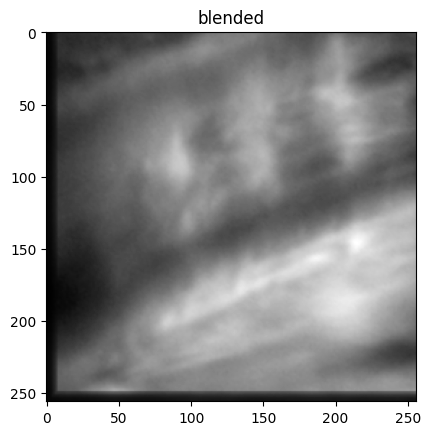

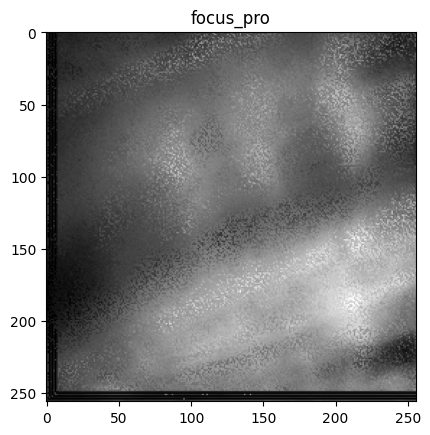

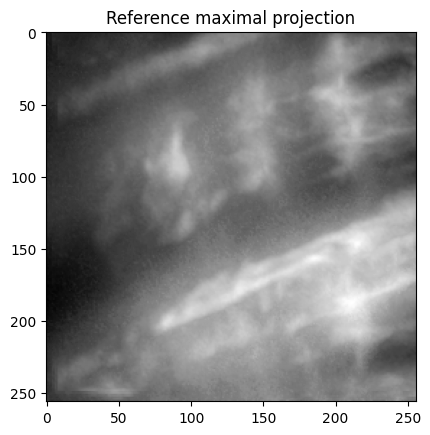

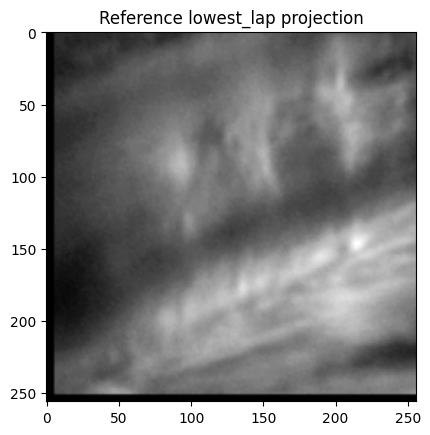

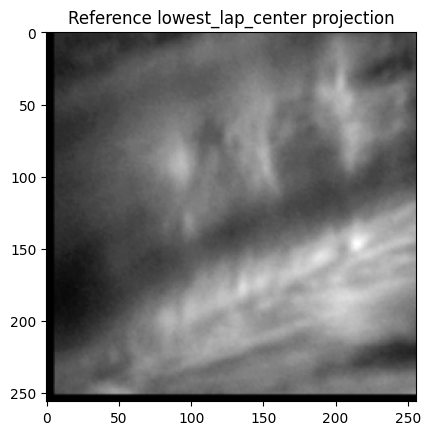

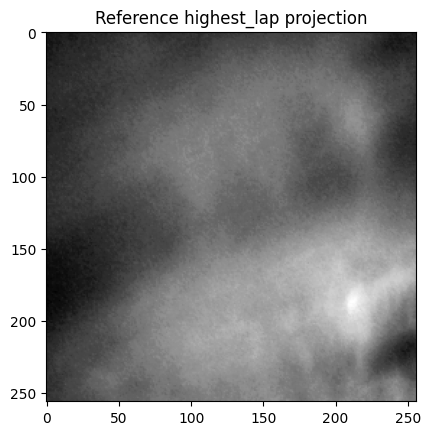

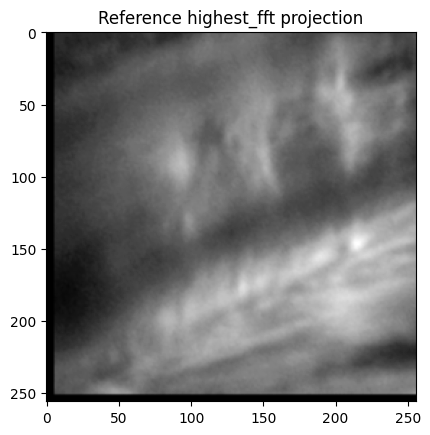

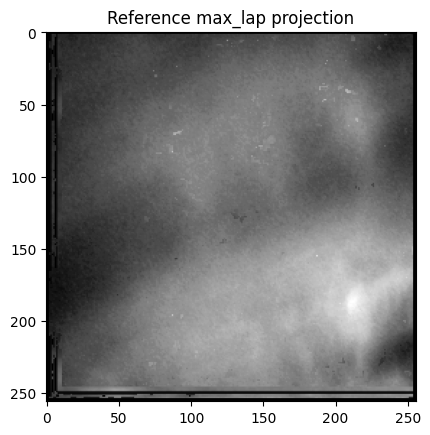

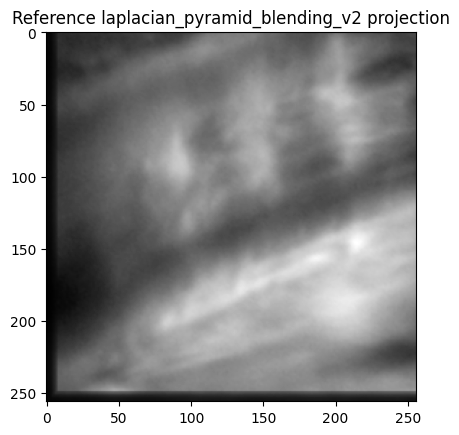

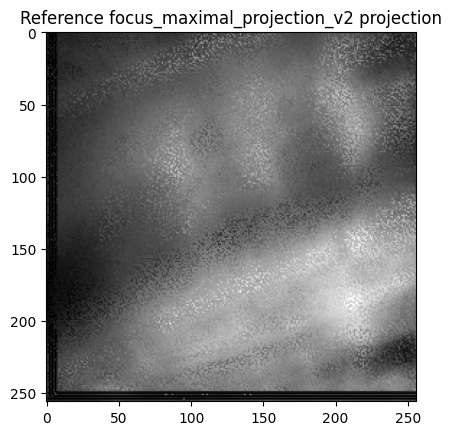

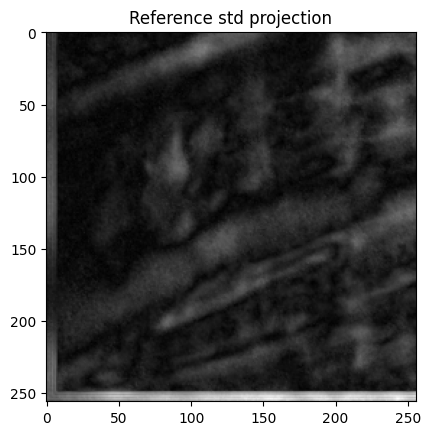

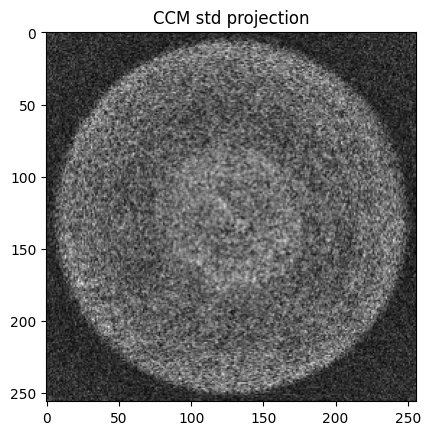

In [10]:
import numpy as np
import skimage.transform as skt
import matplotlib.pyplot as plt
import matplotlib.image
import scipy.io as sio
import os
import skimage.transform as skt
import cv2

def maximal_projection(images):
    return np.max(images, axis=0)

def lowest_lap(image_stack):
    """
    Performs focus stacking on a z-stack using variance of Laplacian for focus measure.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image.
    """

    if len(z_stack_ref_imgs) == 0:  # check if list is empty
        print("Warning: No valid images in z-stack starting at {}.".format(X))
        return None, None  # return sentinel values
        
    # Calculate the Laplacian of each image and compute the focus measure
    focus_measure = np.array([cv2.Laplacian(img.astype(np.float64), cv2.CV_64F).var() for img in image_stack])
    
    # Find the index of the image with the best focus measure
    best_focus_idx = np.argmin(focus_measure)
    
    # Return the image with the best focus measure
    return image_stack[best_focus_idx], best_focus_idx

def lowest_lap_center(image_stack):
    """
    Performs focus stacking on a z-stack using variance of Laplacian for focus measure,
    considering only the center 100x100 square of each image.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image.
    """

    if len(image_stack) == 0:  # check if list is empty
        print("Warning: No valid images in z-stack.")
        return None, None  # return sentinel values

    focus_measure = []
    for img in image_stack:
        # Get the dimensions of the image
        height, width = img.shape[:2]
        # Calculate the starting point for the 100x100 center square
        start_x = width//2 - 50
        start_y = height//2 - 50
        # Extract the center 100x100 square of the image
        center_square = img[start_y:start_y+100, start_x:start_x+100]
        # Calculate the Laplacian of the center square and compute the focus measure
        focus_measure.append(cv2.Laplacian(center_square.astype(np.float64), cv2.CV_64F).var())

    # Convert the focus measure list to a NumPy array
    focus_measure = np.array(focus_measure)
    
    # Find the index of the image with the best focus measure
    best_focus_idx = np.argmin(focus_measure)
    
    # Return the image with the best focus measure
    return image_stack[best_focus_idx], best_focus_idx

def highest_lap(image_stack):
    """
    Performs focus stacking on a z-stack using variance of Laplacian for focus measure.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image.
    """

    if len(z_stack_ref_imgs) == 0:  # check if list is empty
        print("Warning: No valid images in z-stack starting at {}.".format(X))
        return None, None  # return sentinel values
        
    # Calculate the Laplacian of each image and compute the focus measure
    focus_measure = np.array([cv2.Laplacian(img.astype(np.float64), cv2.CV_64F).var() for img in image_stack])
    
    # Find the index of the image with the best focus measure
    best_focus_idx = np.argmax(focus_measure)
    
    # Return the image with the best focus measure
    return image_stack[best_focus_idx], best_focus_idx

def lowest_lap2(image_stack):
    """
    Performs focus stacking on a z-stack using variance of Laplacian for focus measure.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    List[numpy.ndarray]: List of 2D NumPy arrays representing the top 3 focus-stacked images.
    List[int]: List of indices of the top 3 images.
    """

    if len(image_stack) == 0:  # check if array is empty
        print("Warning: No valid images in z-stack.")
        return None, None  # return sentinel values
        
    # Calculate the Laplacian of each image and compute the focus measure
    focus_measure = np.array([cv2.Laplacian(img.astype(np.float64), cv2.CV_64F).var() for img in image_stack])
    
    # Find the indices of the images with the top 3 best focus measures
    best_focus_indices = np.argsort(focus_measure)[:3]
    
    # Check if there are less than 3 images
    if best_focus_indices.size < 3:
        print("Warning: Less than 3 valid images in z-stack.")
        return None, None  # return sentinel values

    # Return the top 3 images with the best focus measures
    return [image_stack[idx] for idx in best_focus_indices], best_focus_indices.tolist()

def mergeImages(img1, img2, img3):
    a1 = cv2.split(img1)
    a2 = cv2.split(img2)
    a3 = cv2.split(img3)

    # cv2.imwrite('image1', img1)
    # cv2.imwrite('image2', img2)
    # cv2.imwrite('image3', img3)
    # cv2.imwrite('imagemerged', cv2.merge((a1, a2, a3)))
    # cv2.waitKey(0)

    return cv2.merge((a1[0], a2[0], a3[0]))

# sort image_stack based on the best images and then combine them into 1 image
def mergeLowestLap(image_stack):
    a = lowest_lap2(image_stack)
    return mergeImages(a[0][0], a[0][1], a[0][2]), a[1][0]

def highest_fft(image_stack):
    """
    Selects the image from a z-stack with the highest Fourier transform, using mean of magnitude spectrum as measure.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    numpy.ndarray, int: 2D NumPy array representing the selected image and the index of that image.
    """

    # Calculate the FFT and the mean magnitude spectrum of each image
    mean_magnitude_spectrums = []
    for img in image_stack:
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))
        mean_magnitude_spectrum = magnitude_spectrum.mean()
        mean_magnitude_spectrums.append(mean_magnitude_spectrum)
    
    # Convert to numpy array for argmax operation
    mean_magnitude_spectrums = np.array(mean_magnitude_spectrums)
    
    # Find the index of the image with the highest mean magnitude spectrum
    best_fft_idx = np.argmax(mean_magnitude_spectrums)
    
    # Return the image with the highest mean magnitude spectrum and its index
    return image_stack[best_fft_idx], best_fft_idx


def max_lap_projection(image_stack, window_size=5):
    """
    Performs focus stacking with maximal projection on a z-stack using variance of Laplacian for focus measure,
    calculated over a sliding window.

    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.
    window_size (int): The size of the sliding window.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image with maximal projection.
    """
    if len(z_stack_ref_imgs) == 0:  # check if list is empty
        print("Warning: No valid images in z-stack starting at {}.".format(X))
        return None, None  # return sentinel values
        
    # Compute the Laplacian of each image
    laplacian_images = np.array([cv2.Laplacian(img.astype(np.float64), cv2.CV_64F) for img in image_stack])
    
    # Create an empty image to store the focus-stacked and maximally projected image
    combined_image = np.zeros_like(image_stack[0])
    
    # Define half window size
    half_window = window_size // 2
    
    # For each window location, choose the pixel from the image with the highest focus measure
    for i in range(half_window, image_stack.shape[1] - half_window):
        for j in range(half_window, image_stack.shape[2] - half_window):
            # Get the window for each Laplacian image
            windows = [lap[i-half_window:i+half_window+1, j-half_window:j+half_window+1] for lap in laplacian_images]
            
            # Compute the variance of each window
            variances = [np.var(window) for window in windows]
            
            # Get the image index with the highest variance
            idx = np.argmax(variances)
            
            # Set the pixel in the combined image to the pixel from the image with the highest variance
            combined_image[i, j] = image_stack[idx, i, j]
    
    return combined_image

def focus_maximal_projection(image_stack):
    """
    Performs focus stacking with maximal projection on a z-stack using variance of Laplacian for focus measure.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image with maximal projection.
    """

    if len(z_stack_ref_imgs) == 0:  # check if list is empty
        print("Warning: No valid images in z-stack starting at {}.".format(X))
        return None, None  # return sentinel values
        
    # Compute the Laplacian of each image
    laplacian_images = np.array([cv2.Laplacian(img.astype(np.float64), cv2.CV_64F) for img in image_stack])
    
    # Compute the variance of each Laplacian image
    focus_measure = np.var(laplacian_images, axis=(1, 2))
    
    # Create an empty image to store the focus-stacked and maximally projected image
    combined_image = np.zeros_like(image_stack[0])
    
    # For each pixel location, choose the pixel from the image with the highest focus measure
    for i in range(image_stack.shape[1]):
        for j in range(image_stack.shape[2]):
            # Get the image index with the highest focus measure at the current pixel location
            idx = np.argmax([lap[i, j] for lap in laplacian_images])
            # Set the pixel in the combined image to the pixel from the image with the highest focus measure
            combined_image[i, j] = image_stack[idx, i, j]
    
    return combined_image


from skimage.filters import laplace
import numpy as np
import cv2


def std_projection(images):

    img = np.std(images, axis=0)
    img = img - np.min(img)
    img = np.single(img / np.max(img))
    return img
    
def pyr_blending(img1, img2, mask, levels=6):
    # Check that images are 2D or 3D (for grayscale or RGB images, respectively)
    assert 2 <= img1.ndim <= 3, "Image 1 must be 2D or 3D"
    assert 2 <= img2.ndim <= 3, "Image 2 must be 2D or 3D"
    assert 2 <= mask.ndim <= 3, "Mask must be 2D or 3D"

    
    # Convert images and mask to float32 if necessary
    if img1.dtype != np.float32:
        img1 = img1.astype(np.float32)
    if img2.dtype != np.float32:
        img2 = img2.astype(np.float32)
    if mask.dtype != np.float32:
        mask = mask.astype(np.float32)
    # Generate Gaussian pyramid for the mask
    G = mask.copy()
    gpM = [G]
    for i in range(levels):
        G = cv2.pyrDown(G)
        gpM.append(G)

    # Generate Gaussian pyramids for the two images
    gpA = [img1.copy()]
    gpB = [img2.copy()]
    for i in range(levels):
        img1 = cv2.pyrDown(img1)
        img2 = cv2.pyrDown(img2)
        gpA.append(np.float32(img1))
        gpB.append(np.float32(img2))

    # Generate Laplacian Pyramids for the two images
    lpA = [gpA[levels-1]]
    lpB = [gpB[levels-1]]
    for i in range(levels-1, 0, -1):
        size = (gpA[i-1].shape[1], gpA[i-1].shape[0])
        LA = np.subtract(gpA[i-1], cv2.pyrUp(gpA[i], dstsize=size))
        LB = np.subtract(gpB[i-1], cv2.pyrUp(gpB[i], dstsize=size))
        lpA.append(LA)
        lpB.append(LB)

    # Add left and right halves of images in each level
    LS = []
    for la, lb, gm in zip(lpA, lpB, gpM):
        # Resize gm to match the size of la and lb
        gm = cv2.resize(gm, (la.shape[1], la.shape[0]))
        ls = la * gm + lb * (1.0 - gm)
        LS.append(ls)

    # Reconstruct
    ls_ = LS[0]
    for i in range(1, levels):
        size = (LS[i].shape[1], LS[i].shape[0])
        ls_ = cv2.pyrUp(ls_, dstsize=size)
        ls_ = cv2.add(ls_, LS[i])

    return ls_

def laplacian_pyramid_blending(image_stack, levels=6):
    """
    Performs focus stacking on a z-stack using Laplacian pyramid blending method used by Photoshop.

    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.
    levels (int): The number of levels in the pyramids.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image.
    """

    focus_measures = np.array([laplace(img) for img in image_stack])

    # Initialize blended as the first image in the stack
    blended = image_stack[0].copy()

    for i in range(1, image_stack.shape[0]):

        # Create a mask where the current image is more in focus than the current blended image
        mask = np.zeros_like(image_stack[0], dtype=np.float32)
        mask[focus_measures[i] > laplace(blended)] = 1.0


        # Convert the mask to binary
        mask = np.where(focus_measures[i] > laplace(blended), 1, 0)
        # Blend the current image with the current blended image using the mask
        blended = pyr_blending(blended, image_stack[i], mask, levels)
        # normalize blended = (blended - np.min(blended)) / (np.max(blended) - np.min(blended))

    return blended



def focus_maximal_projection_v2(image_stack):
    """
    Performs focus stacking with maximal projection on a z-stack using variance of Laplacian for focus measure.
    
    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image with maximal projection.
    """

    #if len(image_stack) == 0:  # check if stack is empty
    #    print("Warning: No valid images in z-stack.")
    #    return None, None  # return sentinel values
        
    # Compute the Laplacian of each image
    laplacian_images = np.array([cv2.Laplacian(img.astype(np.float64), cv2.CV_64F) for img in image_stack])
    
    # Compute the variance of each Laplacian image
    focus_measure = np.var(laplacian_images, axis=(1, 2))
    
    # Create an empty image to store the focus-stacked and maximally projected image
    combined_image = np.zeros_like(image_stack[0])
    
    # For each pixel location, choose the pixel from the image with the highest focus measure
    for i in range(image_stack.shape[1]):
        for j in range(image_stack.shape[2]):
            # Get the image index with the highest focus measure at the current pixel location
            idx = np.argmax([lap[i, j] for lap in laplacian_images])
            # Set the pixel in the combined image to the pixel from the image with the highest focus measure
            combined_image[i, j] = image_stack[idx, i, j]
    plt.figure()
    plt.imshow(combined_image, cmap='gray')
    plt.title('focus_pro')
    return combined_image

def laplacian_pyramid_blending_v2(image_stack, levels=6):
    """
    Performs focus stacking on a z-stack using Laplacian pyramid blending method used by Photoshop.

    Parameters:
    image_stack (numpy.ndarray): 3D NumPy array where the first dimension represents 
    the different images in the z-stack and the next two are the x and y coordinates 
    of each image.
    levels (int): The number of levels in the pyramids.

    Returns:
    numpy.ndarray: 2D NumPy array representing the focus-stacked image.
    """

    focus_measures = np.array([laplace(img) for img in image_stack])

    # Initialize blended as the first image in the stack
    blended = image_stack[0].copy()

    for i in range(1, image_stack.shape[0]):

        # Create a mask where the current image is more in focus than the current blended image
        mask = np.zeros_like(image_stack[0], dtype=np.float32)
        mask[focus_measures[i] > laplace(blended)] = 1.0


        # Convert the mask to binary
        mask = np.where(focus_measures[i] > laplace(blended), 1, 0)
        # Blend the current image with the current blended image using the mask
        blended = pyr_blending(blended, image_stack[i], mask, levels)
        print(np.shape(blended))
        plt.figure()
        plt.imshow(blended, cmap='gray')
        plt.title('blended')
    return blended


# Function to align images
def align_images(im1, im2):
    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(im1, im2, warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

    return im2_aligned
 

#reshape_shape = [256, 256]
#Dir = '/media/alingold/MenonLab/20230819_plant50um'
#CCMcrop = [226, 472, 216, 462] 
#REFcrop = [410, 810, 400, 800]

reshape_shape = [256, 256]
Dir = '/media/alingold/MenonLab/20230919_youngTestTile'
CCMcrop = [225, 480, 220, 475] 
REFcrop = [430, 820, 425, 815]

Len = len(os.listdir(Dir)) - 3
# Len = 19476
#Len = 1305
ref_imgs = []
ccm_imgs = []

z_stack_size = 5
Y = 0

projections = ['maximal', 'lowest_lap', 'lowest_lap_center', 'highest_lap', 'highest_fft', 'max_lap', 'laplacian_pyramid_blending_v2', 'focus_maximal_projection_v2', 'std']


for X in range(1511, 1512): # 101 + z_stack_size - 1):
    if X % 100 == 0:
        print(X)

    z_stack_ref_imgs = []
    z_stack_ccm_imgs = []
    for Z in range(z_stack_size):
        Mat = "{}.mat".format(X + Z)
        Path = os.path.join(Dir, Mat)
        Struct = sio.loadmat(Path, verify_compressed_data_integrity=False)
        Struct.keys()
        
        ref_img = Struct["objRef"]
        ccm_img = Struct["objCCM"]
        
        if ccm_img.size < 1:
            Exp = "{}.mat CCM is empty".format(X)
            print(Exp)
            continue
        if ref_img.size < 1:
            Exp = "{}.mat Ref is empty".format(X)
            print(Exp)
            continue
        if np.max(ccm_img) > 65530:
            Exp = "{}.mat CCM is overexposed".format(X)
            print(Exp)
            print(np.max(ccm_img))
            continue
        if np.max(ref_img) > 254: 
            Exp = "{}.mat Ref is overexposed".format(X)
            print(Exp)
            print(np.max(ref_img))
            continue
        if np.max(ref_img) == 1:
            Exp = "{}.mat Ref is has a max of 1".format(X)
            print(Exp)
            continue

        ref_img = ref_img[REFcrop[2]:REFcrop[3], REFcrop[0]:REFcrop[1]]
        ref_img = ref_img - np.min(ref_img)
        ref_img = np.single(ref_img / np.max(ref_img))
        ref_img = skt.resize(ref_img, reshape_shape)
        plt.figure()
        plt.imshow(ref_img, cmap='gray')
        z_stack_ref_imgs.append(ref_img)


        ccm_img = ccm_img[CCMcrop[2]:CCMcrop[3], CCMcrop[0]:CCMcrop[1]]
        ccm_img = ccm_img - np.min(ccm_img)
        ccm_img = np.single(ccm_img / np.max(ccm_img))
        ccm_img = skt.resize(ccm_img, reshape_shape)
        z_stack_ccm_imgs.append(ccm_img)

    
    # Convert lists to numpy arrays
    z_stack_ref_imgs = np.array(z_stack_ref_imgs)
    z_stack_ccm_imgs = np.array(z_stack_ccm_imgs)

    z_stack_ref_imgs = np.array([align_images(z_stack_ref_imgs[0], img) for img in z_stack_ref_imgs])
    print(np.shape(z_stack_ref_imgs))
    
    # Generate the projections
    ref_projs = {
        'maximal': maximal_projection(z_stack_ref_imgs),
        'lowest_lap': lowest_lap(z_stack_ref_imgs)[0],
        'lowest_lap_center': lowest_lap_center(z_stack_ref_imgs)[0],
        'highest_lap': highest_lap(z_stack_ref_imgs)[0],
        'highest_fft': highest_fft(z_stack_ref_imgs)[0],
        'max_lap': max_lap_projection(z_stack_ref_imgs),
        'laplacian_pyramid_blending_v2': laplacian_pyramid_blending_v2(z_stack_ref_imgs),
        'focus_maximal_projection_v2': focus_maximal_projection_v2(z_stack_ref_imgs),
        'std': std_projection(z_stack_ref_imgs),
    }
    
    ccm_projs = {
        'std': std_projection(z_stack_ccm_imgs),
        'index': z_stack_ccm_imgs[lowest_lap(z_stack_ref_imgs)[1]]
    }

    
    ref_imgs.append(ref_projs['max_lap'])
    ccm_imgs.append(ccm_projs['index'])
    
    # Plot and save all projections
    for proj in projections:
        # Reference projections
        if proj in ref_projs:
            plt.figure()
            plt.imshow(ref_projs[proj], cmap='gray')
            plt.title(f'Reference {proj} projection')
            # plt.savefig(f'reference_{proj}_projection_{X}.png')  # Save figure
        
        # CCM projections
        if proj in ccm_projs:
            plt.figure()
            plt.imshow(ccm_projs[proj], cmap='gray')
            plt.title(f'CCM {proj} projection')
            # plt.savefig(f'ccm_{proj}_projection_{X}.png')  # Save figure



In [12]:
#ref_imgs = np.array( ref_imgs)
#ccm_imgs = np.array( ccm_imgs)
#dir = '20230708_minLapCenter'
np.save(Dir + '_LowLap_ccm.npy', ccm_imgs)
np.save(Dir + '_LowLap_ref.npy', ref_imgs)
ccm_imgs.shape

(485, 256, 256)

In [11]:
import numpy as np
import skimage.transform as skt
import matplotlib.pyplot as plt
import matplotlib.image
import scipy.io as sio
import os
import skimage.transform as skt
import cv2
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import psutil
from functools import partial
import gc

def check_memory(threshold=0.1):
    """Checks if available memory is less than threshold (default 10%)."""
    mem = psutil.virtual_memory()
    return mem.available / mem.total < threshold

def process_z_stack(X, Len, z_stack_size):
    if check_memory():
        print(f"Low memory detected! Stopping at index {X}")
        return None, None
        
    z_stack_ref_imgs = np.empty((z_stack_size,) + reshape_shape, dtype=np.single)
    z_stack_ccm_imgs = np.empty((z_stack_size,) + reshape_shape, dtype=np.single)

    actual_z_stack_size = 0

    for Z in range(1, z_stack_size):
        if X + Z >= Len:
            break

        Mat = "{}.mat".format(X + Z)
        Path = os.path.join(Dir, Mat)
        if not os.path.isfile(Path):
            continue

        Struct = sio.loadmat(Path, verify_compressed_data_integrity=False)
        
        ref_img = Struct["objRef"]
        ccm_img = Struct["objCCM"]
        ccm_max = np.max(ccm_img)
        ref_max = np.max(ref_img)
        ref_min = np.min(ref_img)
        ccm_min = np.min(ccm_img)

        
        if ccm_img.size < 1:
            Exp = "{}.mat CCM is empty".format(X)
            print(Exp)
            continue
        if ref_img.size < 1:
            Exp = "{}.mat Ref is empty".format(X)
            print(Exp)
            continue
        if ccm_max > 65530:
            Exp = "{}.mat CCM is overexposed".format(X)
            print(Exp)
            print(ccm_max)
            continue
        if ref_max > 254:
            Exp = "{}.mat Ref is overexposed".format(X)
            print(Exp)
            print(ref_max)
            continue
        if ref_max == 1:
            Exp = "{}.mat Ref is has a max of 1".format(X)
            print(Exp)
            continue

        ref_img = ref_img[REFcrop[2]:REFcrop[3], REFcrop[0]:REFcrop[1]]
        ref_img = np.single((ref_img - ref_min) / (ref_max - ref_min))
        ref_img = skt.resize(ref_img, reshape_shape)

        ccm_img = ccm_img[CCMcrop[2]:CCMcrop[3], CCMcrop[0]:CCMcrop[1]]
        ccm_img = np.single((ccm_img - ccm_min) / (ccm_max - ccm_min))
        ccm_img = skt.resize(ccm_img, reshape_shape)
        
        z_stack_ref_imgs[actual_z_stack_size] = ref_img
        z_stack_ccm_imgs[actual_z_stack_size] = ccm_img
        actual_z_stack_size += 1

    # Trim arrays to actual size
    z_stack_ref_imgs = z_stack_ref_imgs[:actual_z_stack_size]
    z_stack_ccm_imgs = z_stack_ccm_imgs[:actual_z_stack_size]

    if actual_z_stack_size == 0: 
        print("No valid images in the stack for index: ", X)
        return None, None

    
    [ref_max_proj, index] = lowest_lap(z_stack_ref_imgs)
    ccm_max_proj = z_stack_ccm_imgs[index]
    
    #ref_max_proj = std_projection(z_stack_ref_imgs)
    
    #[ref_max_proj, index] = mergeLowestLap(z_stack_ref_imgs)
    #[ccm_max_proj, index] = mergeLowestLap(z_stack_ccm_imgs)
    gc.collect()
    return ref_max_proj, ccm_max_proj


Len = len(os.listdir(Dir)) - 5
# Len = 100
Y = 0
reshape_shape = tuple(reshape_shape)
estimated_img_count = (Len - 1) // z_stack_size + 1
# Initialize the images to store 1 color channel
ref_imgs = np.empty((estimated_img_count,) + reshape_shape, dtype=np.single)
ccm_imgs = np.empty((estimated_img_count,) + reshape_shape, dtype=np.single)
# Initialize the images to store 3 color channels
#ref_imgs = np.empty((estimated_img_count,) + reshape_shape + (3,), dtype=np.single)
#ccm_imgs = np.empty((estimated_img_count,) + reshape_shape + (3,), dtype=np.single)
actual_img_count = 0

# Use partial function application to supply additional arguments
process_func = partial(process_z_stack, Len=Len, z_stack_size=z_stack_size)

# Use ThreadPoolExecutor with the defined number of workers
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust based on your requirements
    results = list(tqdm(executor.map(process_func, range(0, Len, z_stack_size)), total=estimated_img_count))

for ref_max_proj, ccm_max_proj in results:
    if ref_max_proj is None or ccm_max_proj is None:  # skip if sentinel values are received
        continue
    ref_imgs[actual_img_count] = ref_max_proj
    ccm_imgs[actual_img_count] = ccm_max_proj
    actual_img_count += 1

# Trim arrays to actual size
ref_imgs = ref_imgs[:actual_img_count]
ccm_imgs = ccm_imgs[:actual_img_count]

# dir = '/media/alingold/MenonLab/20230720_50um_long_minlap'
#np.save(Dir + '_ccm.npy', ccm_imgs)
#np.save(Dir + '_ref.npy', ref_imgs)

100%|█████████████████████████████████████████| 485/485 [01:10<00:00,  6.85it/s]


In [2]:
import numpy as np

# Load the two NumPy arrays
imgs1 = np.load('not_blurry_2.npy')
imgs2 = np.load('not_blurry_1.npy')
#imgs3 = np.load('/home/alingold/Training/20230719_timelapse_Fresh_Stain_ccm_pro.npy')
# Append the two arrays
# combined_imgs = np.append(imgs1, imgs2, imgs3, axis=0)
combined_imgs = np.concatenate((imgs1, imgs2), axis=0)

# Save the combined array
np.save('not_blurry.npy', combined_imgs)
